In [179]:

#Start with importing the usual stuff

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.pyplot import subplots
import seaborn as sns

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, datasets
from sklearn import metrics

pd.options.mode.copy_on_write = True # This contains some functions written by the authors of the textbook (ISLP)
# we'll be adapting most of the this demo from their material

from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)


In [8]:
def abline(ax, b, m, *args, **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim, ylim, *args, **kwargs)
    
def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

def mse(y, y_hat):
    # calculate the residual error for each individual record
    resid = y - y_hat
    # square the residual (hence "squared error")
    sq_resid = resid**2
    # calculate the sum of squared errors
    SSR = sum(sq_resid)
    # divide by the number of records to get the mean squared error
    MSE = SSR / y.shape[0]
    return MSE

## Auto data Q1

In [3]:
auto = load_data("auto")
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [138]:
x_train = auto.drop(columns = ['mpg', 'name'])
y_train = auto['mpg']

x_train['intercept'] = np.ones(auto.shape[0])

In [139]:
#x_train, x_test, y_train, y_test = train_test_split(auto_x, auto_y, test_size=0.25, random_state=314, shuffle=True)

In [140]:
results_model_all = sm.OLS(y_train, x_train).fit()
summarize(results_model_all)

,coef,std err,t,P>|t|
cylinders,-0.4934,0.323,-1.526,0.128
displacement,0.0199,0.008,2.647,0.008
horsepower,-0.0170,0.014,-1.230,0.220
weight,-0.0065,0.001,-9.929,0.000
acceleration,0.0806,0.099,0.815,0.415
year,0.7508,0.051,14.729,0.000
origin,1.4261,0.278,5.127,0.000
intercept,-17.2184,4.644,-3.707,0.000


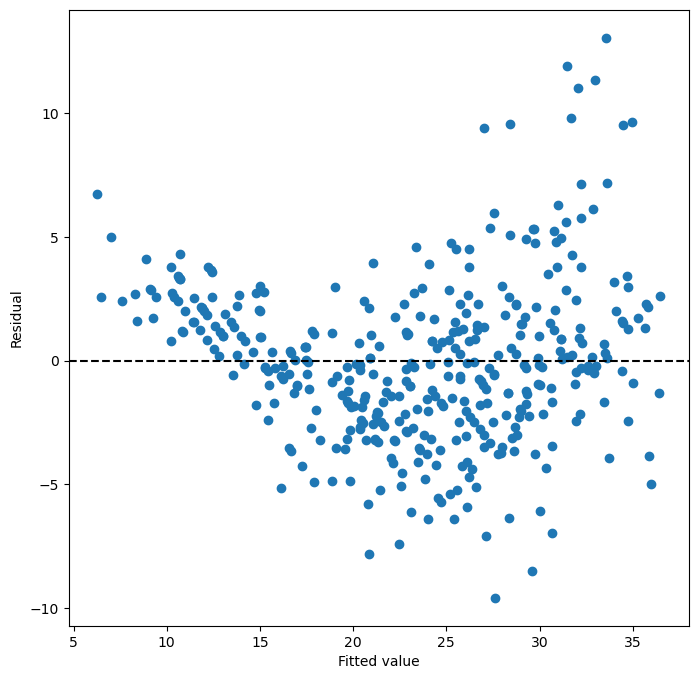

In [141]:
predict_all_train = predict(x_train, results_model_all)
predict_all_test = predict(x_test, results_model_all)

ax = subplots(figsize=(8,8))[1]
ax.scatter(predict_all_train, y_train - predict_all_train)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

In [142]:
print('train: ', mse(y_train, predict_all_train))
print('test: ', mse(y_test, predict_all_test))

train:  10.847480945000452
test:  10.96064064378709


In [143]:
summarize(results_model_all).axes

[Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
        'year', 'origin', 'intercept'],
       dtype='object'),
 Index(['coef', 'std err', 't', 'P>|t|'], dtype='object')]

In [144]:
sig_feature_list = list()

for count, row in enumerate(summarize(results_model_all)['P>|t|']):
    if row == 0:
        sig_feature_list.append(summarize(results_model_all).axes[0][count])
        
sig_feature_list

['weight', 'year', 'origin', 'intercept']

In [145]:
results_model_sig = sm.OLS(y_train, x_train[sig_feature_list]).fit()
summarize(results_model_sig)

,coef,std err,t,P>|t|
weight,-0.0060,0.000,-23.588,0.0
year,0.7571,0.048,15.668,0.0
origin,1.1504,0.259,4.439,0.0
intercept,-18.0459,4.001,-4.510,0.0


In [146]:
predict_sig_train = predict(x_train[sig_feature_list], results_model_sig)
predict_sig_test = predict(x_test[sig_feature_list], results_model_sig)

print(f"train: {mse(y_train, predict_sig_train)}")
print(f"test: {mse(y_test, predict_sig_test)}")

train: 11.09210519086095
test: 11.675371363733289


In [147]:
poly_x_train = MS([poly('weight', degree=2), 'weight', 'year', 'origin', 'intercept']).fit_transform(x_train)

results_model_poly = sm.OLS(y_train, poly_x_train).fit()

summarize(results_model_poly)

,coef,std err,t,P>|t|
intercept,-10.5151,1.785,-5.892,0.00
"poly(weight, degree=2)[0]",1.8641,0.316,5.892,0.00
"poly(weight, degree=2)[1]",30.2044,3.184,9.487,0.00
weight,-0.0064,0.000,-28.603,0.00
year,0.8247,0.044,18.675,0.00
origin,0.5026,0.243,2.064,0.04
intercept,-10.5151,1.785,-5.892,0.00


In [148]:
predict_poly_train = predict(poly_x_train, results_model_poly)
poly_x_test = MS([poly('weight', degree=2), 'weight', 'year', 'origin', 'intercept']).fit_transform(x_test)
predict_poly_test = predict(poly_x_test, results_model_poly)

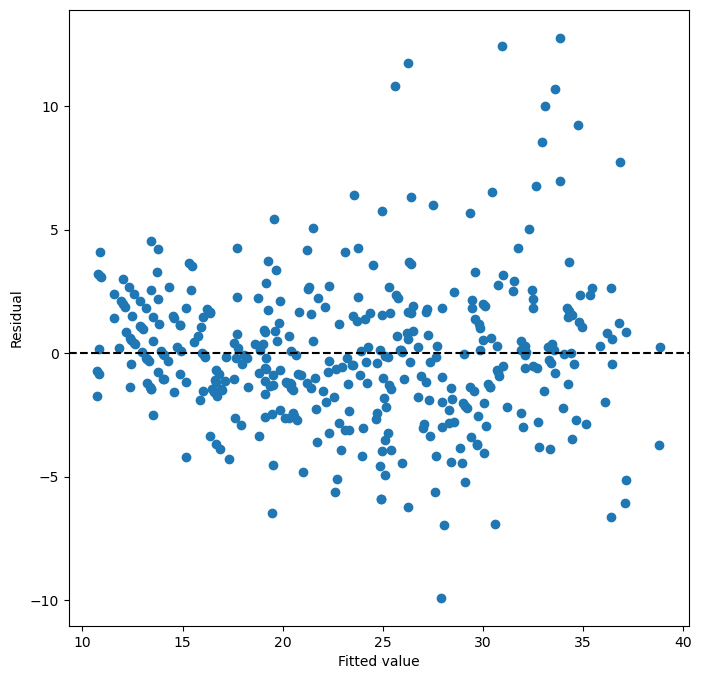

In [149]:
ax = subplots(figsize=(8,8))[1]
ax.scatter(predict_poly_train, y_train - predict_poly_train)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

## Carseast data

In [51]:
carseats =  load_data('carseats')

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [67]:
carseats['US_Domestic'] = pd.Series(np.zeros(carseats.shape[0]))
carseats.loc[carseats['US']=='Yes', 'US_Domestic'] = 1
carseats['intercept'] = pd.Series(np.ones(carseats.shape[0]))

carseat_x = carseats.drop(columns=['Sales'])
carseat_y = carseats['Sales']

carseat_train_x, carseat_test_y, carseat_train_y, carseat_test_y = train_test_split(carseat_x, carseat_y, test_size=0.25, random_state=314, shuffle=True)

carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,US_Domestic,intercept
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1.0,1.0
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1.0,1.0
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1.0,1.0
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,1.0,1.0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes,1.0,1.0
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes,1.0,1.0
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes,1.0,1.0
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes,1.0,1.0


In [63]:
result_model_carseat = sm.OLS(carseat_train_y, carseat_train_x[['intercept', 'Price', 'US_Domestic']]).fit()
summarize(result_model_carseat)

,coef,std err,t,P>|t|
intercept,12.7814,0.753,16.975,0.000
Price,-0.0512,0.006,-8.122,0.000
US_Domestic,1.0599,0.303,3.499,0.001


In [71]:
carseat_x_interaction = MS(['intercept', 'Price', 'US_Domestic', ('Price', 'US_Domestic')]).fit_transform(carseat_train_x)

In [72]:
result_model_carseat_inter = sm.OLS(carseat_train_y, carseat_x_interaction).fit()
summarize(result_model_carseat_inter)

,coef,std err,t,P>|t|
intercept,5.9990,0.564,10.645,0.000
intercept,5.9990,0.564,10.645,0.000
Price,-0.0443,0.010,-4.555,0.000
US_Domestic,2.4276,1.495,1.624,0.106
Price:US_Domestic,-0.0119,0.013,-0.934,0.351


In [121]:
weekly = load_data('weekly')
weekly['Direction_int'] = pd.Series(np.zeros(weekly.shape[0]))
weekly.loc[weekly['Direction']=='Up', 'Direction_int'] = 1

weekly_train = (weekly[weekly['Year'] <= 2005]).drop(columns=['Direction'])
weekly_test = weekly[weekly['Year'] > 2005].drop(columns=['Direction'])

In [122]:
weekly_train.mean()

Year             1997.543478
Lag1                0.184471
Lag2                0.186242
Lag3                0.180726
Lag4                0.180994
Lag5                0.177088
Volume              0.767336
Today               0.181546
Direction_int       0.559179
dtype: float64

In [123]:
weekly_train.std()

Year             4.586853
Lag1             2.098292
Lag2             2.098845
Lag3             2.103670
Lag4             2.103603
Lag5             2.107403
Volume           0.558954
Today            2.099099
Direction_int    0.496786
dtype: float64

In [124]:
weekly_train.median()

Year             1998.000000
Lag1                0.278000
Lag2                0.290000
Lag3                0.278000
Lag4                0.278000
Lag5                0.278000
Volume              0.591209
Today               0.270500
Direction_int       1.000000
dtype: float64

In [125]:
weekly_train.min()

Year             1990.000000
Lag1              -11.050000
Lag2              -11.050000
Lag3              -11.050000
Lag4              -11.050000
Lag5              -11.050000
Volume              0.087465
Today             -11.050000
Direction_int       0.000000
dtype: float64

In [126]:
weekly_train.max()

Year             2005.00000
Lag1                7.78000
Lag2                7.78000
Lag3                7.78000
Lag4                7.78000
Lag5                7.78000
Volume              2.48811
Today               7.78000
Direction_int       1.00000
dtype: float64

<Axes: >

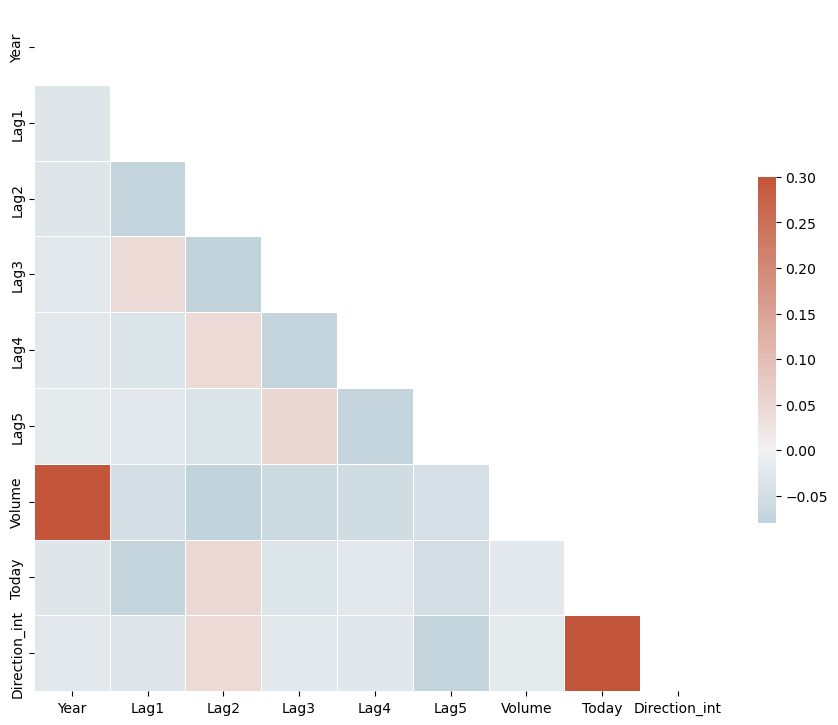

In [127]:
train_corr = weekly_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(train_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(train_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [128]:
weekly_train = weekly_train.join(weekly['Direction'])
weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Direction_int
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0.0
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0.0
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,1.0
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,1.0
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1.0
...,...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up,1.0
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up,1.0
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up,1.0
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up,1.0


In [129]:
results_weekly_log = sm.formula.logit("Direction_int ~ Volume + Lag1 + Lag2 + Lag3 + Lag4 + Lag5", data=weekly_train).fit()
summarize(results_weekly_log)

Optimization terminated successfully.
         Current function value: 0.681053
         Iterations 4


,coef,std err,z,P>|z|
Intercept,0.3295,0.123,2.681,0.007
Volume,-0.0878,0.127,-0.691,0.489
Lag1,-0.0314,0.034,-0.926,0.354
Lag2,0.0376,0.034,1.102,0.271
Lag3,-0.0206,0.034,-0.606,0.544
Lag4,-0.0369,0.034,-1.083,0.279
Lag5,-0.0717,0.034,-2.112,0.035


In [131]:
predict_log_train = predict(weekly_train, results_weekly_log)
predit_log_train_round = list(map(round, predict_log_train))
confusion_log_train = confusion_matrix(weekly_train['Direction_int'], predit_log_train_round)

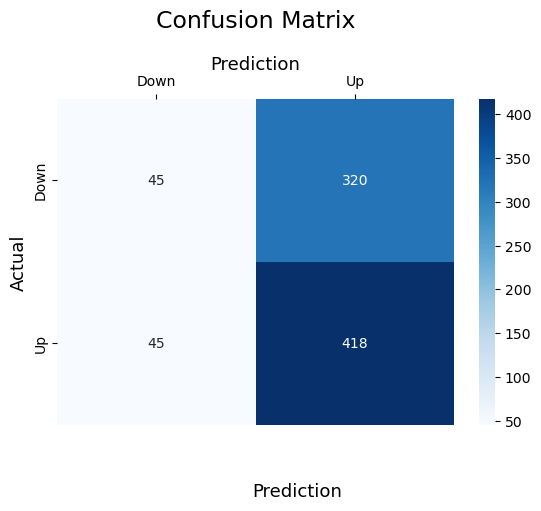

In [134]:
sns.heatmap(confusion_log_train,
            annot=True,
            fmt='g',
            xticklabels=['Down','Up'],
            yticklabels=['Down','Up'],
            cmap='Blues')
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

Optimization terminated successfully.
         Current function value: 0.685104
         Iterations 4


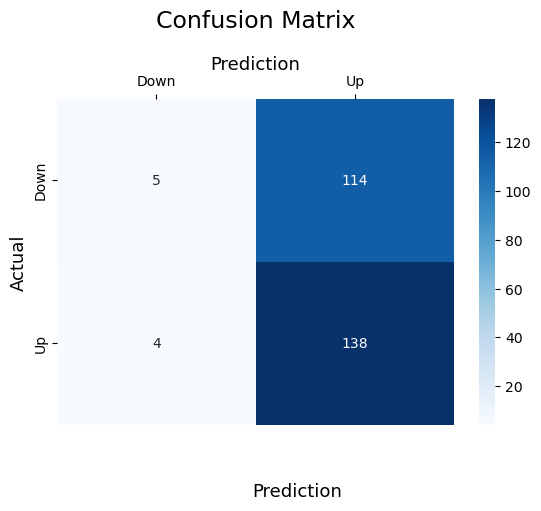

In [198]:
results_weekly_log_lag2 = sm.formula.logit("Direction_int ~ Lag2", data=weekly_train).fit()
summarize(results_weekly_log_lag2)

predict_log_train_lag2 = predict(weekly_test, results_weekly_log_lag2)
predit_log_train_round_lag2 = list(map(round, predict_log_train_lag2))
confusion_log_train_lag2 = confusion_matrix(weekly_test['Direction_int'], predit_log_train_round_lag2)

sns.heatmap(confusion_log_train_lag2,
            annot=True,
            fmt='g',
            xticklabels=['Down','Up'],
            yticklabels=['Down','Up'],
            cmap='Blues')
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

### LDA

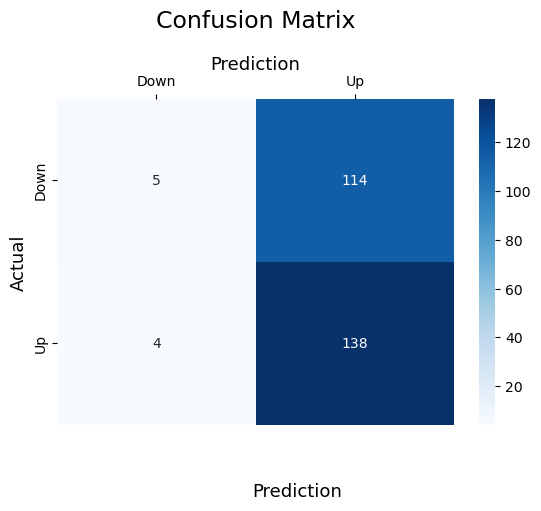

In [199]:
x_LDA = pd.DataFrame(weekly_train.loc[:, 'Lag2'])
y_LDA = weekly_train['Direction_int']
LDA = LinearDiscriminantAnalysis()
LDA.fit(x_LDA, y_LDA)

predict_LDA = LDA.predict(pd.DataFrame(weekly_test.loc[:, 'Lag2']))

confusion_LDA = confusion_matrix(weekly_test['Direction_int'], predict_LDA)

sns.heatmap(confusion_LDA,
            annot=True,
            fmt='g',
            xticklabels=['Down','Up'],
            yticklabels=['Down','Up'],
            cmap='Blues')
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()


### K-neighbors

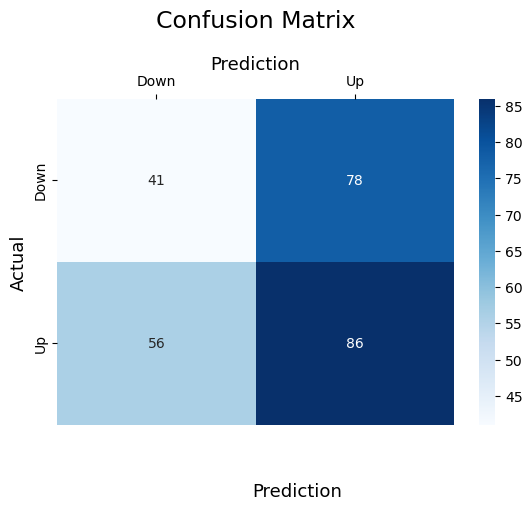

In [200]:
k_neigh = KNeighborsClassifier(n_neighbors=5)
k_neigh.fit(x_LDA, y_LDA)
predict_k = k_neigh.predict(pd.DataFrame(weekly_test.loc[:, 'Lag2']))

confusion_k = confusion_matrix(weekly_test['Direction_int'], predict_k)

sns.heatmap(confusion_k,
            annot=True,
            fmt='g',
            xticklabels=['Down','Up'],
            yticklabels=['Down','Up'],
            cmap='Blues')
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()

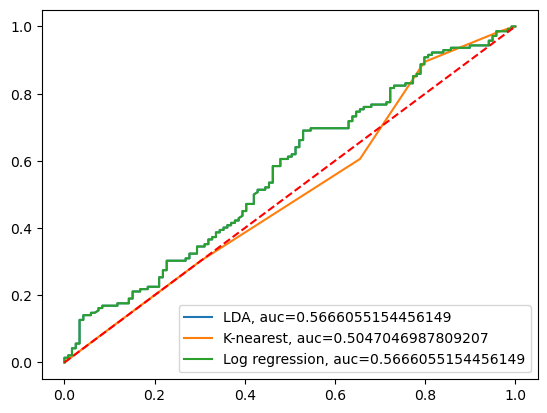

In [201]:
y_pred_proba = LDA.predict_proba(pd.DataFrame(weekly_test.loc[:, 'Lag2']))[::,1]
fpr, tpr, _ = metrics.roc_curve(weekly_test['Direction_int'],  y_pred_proba)
auc = metrics.roc_auc_score(weekly_test['Direction_int'], y_pred_proba)
plt.plot(fpr,tpr,label="LDA, auc="+str(auc))

k_y_pred_proba = k_neigh.predict_proba(pd.DataFrame(weekly_test.loc[:, 'Lag2']))[::,1]
fpr, tpr, _ = metrics.roc_curve(weekly_test['Direction_int'],  k_y_pred_proba)
auc = metrics.roc_auc_score(weekly_test['Direction_int'], k_y_pred_proba)
plt.plot(fpr,tpr,label="K-nearest, auc="+str(auc))

log_y_pred_proba = predict_log_train_lag2
fpr, tpr, _ = metrics.roc_curve(weekly_test['Direction_int'],  log_y_pred_proba)
auc = metrics.roc_auc_score(weekly_test['Direction_int'], log_y_pred_proba)
plt.plot(fpr,tpr,label="Log regression, auc="+str(auc))

plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc=4)
plt.show()

In [ ]:
Sx